In [1]:
 !pip install transformers
!pip install torch
!pip install langgraph
!pip install accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from typing import TypedDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from transformers import pipeline
from langgraph.graph import StateGraph, END


In [3]:
class SentimentState(TypedDict):
    text: str
    processed_text: str
    sentiment: str
    confidence: float
    second_sentiment: str
    second_confidence: float


In [4]:
def preprocess_node(state: SentimentState) -> SentimentState:
    cleaned_text = state["text"].strip()
    return {**state, "processed_text": cleaned_text}

In [5]:
sentiment_pipeline = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None
)


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [6]:
def sentiment_analysis_node(state: SentimentState) -> SentimentState:
    result = sentiment_pipeline(state["processed_text"], top_k=None)
    sorted_result = sorted(result, key=lambda x: x['score'], reverse=True)

    top_emotion = sorted_result[0]['label']
    top_confidence = round(sorted_result[0]['score'], 3)

    second_emotion = sorted_result[1]['label']
    second_confidence = round(sorted_result[1]['score'], 3)

    if top_confidence < 0.5:
        top_emotion = "neutral"
        top_confidence = round(sorted_result[1]['score'], 3)

    return {
        **state,
        "sentiment": top_emotion,
        "confidence": top_confidence,
        "second_sentiment": second_emotion,
        "second_confidence": second_confidence
    }


In [7]:
def logger_node(state: SentimentState) -> SentimentState:
    print("Logging Output:")
    print(f"Text: {state['text']}")
    print(f"Processed: {state['processed_text']}")
    print(f"Sentiment: {state['sentiment']} (Confidence: {state['confidence']})")
    return state

In [8]:
def display_node(state: SentimentState) -> SentimentState:
    print("\nFINAL RESULT")
    print(f"Top Emotion: {state['sentiment']} (Confidence: {state['confidence']})")
    print(f"Second Emotion: {state['second_sentiment']} (Confidence: {state['second_confidence']})")
    return state


In [9]:
graph = StateGraph(SentimentState)
graph.add_node("Preprocess", preprocess_node)
graph.add_node("AnalyzeSentiment", sentiment_analysis_node)
graph.add_node("Logger", logger_node)
graph.add_node("Display", display_node)

graph.set_entry_point("Preprocess")
graph.add_edge("Preprocess", "AnalyzeSentiment")
graph.add_edge("AnalyzeSentiment", "Logger")
graph.add_edge("Logger", "Display")
graph.add_edge("Display", END)

sentiment_graph = graph.compile()

In [12]:
user_text = input("Enter a sentence to analyze its emotion: ")
user_input = {"text": user_text}
final_state = sentiment_graph.invoke(user_input)

Enter a sentence to analyze its emotion: Jayanth is a bad boy
Logging Output:
Text: Jayanth is a bad boy
Processed: Jayanth is a bad boy
Sentiment: disgust (Confidence: 0.899)

FINAL RESULT
Top Emotion: disgust (Confidence: 0.899)
Second Emotion: anger (Confidence: 0.051)


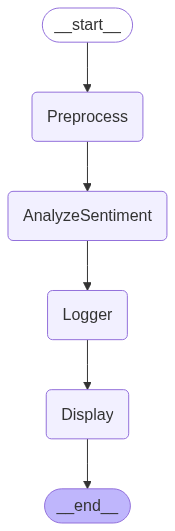

In [ ]:
from IPython.display import Image, display

try:
    display(Image(sentiment_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass